In [236]:
import os
import pandas as pd
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import chromosomeDefinition as cd
import analyseVCF as aVCF

In [3]:
CNV_COLUMNS = ['chrom','posStart','posEnd','copyNum','gainOrLoss','BAF','na','germlineOrSomatic','nothing']
GENECNV_COLUMNS = ['patientName','gene','chrom','posStart','posEnd','minCopyNum','cnvLabel']

In [4]:
# LOAD BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
BED_FILE_NAME = "cosmicCurated.bed" 
BED_FILE_NAME = "cosmicCancerCensus.bed"
#BED_FILE_NAME = "CPCT_Slicing.bed"
bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)

### FUNCTIONS

In [5]:
def findFiles(path,suffix):
    files=[]
    for x in os.listdir(path):
        if x[-len(suffix):] == suffix:
            files.append(x)
    return files

In [6]:
def loadCNVforPatient(cnvFile,patientName):
    dfCNV = pd.read_table(cnvFile, names = CNV_COLUMNS )
    #print dfCNV
    #add regions with default copy number
    last = dfCNV.iloc[0]
    for i in range(1, dfCNV.shape[0]-1):
        #print last.chrom,last.posStart,last.posEnd
        if last['posEnd']<>dfCNV.iloc[i]['posStart']:
            if last['chrom']==dfCNV.iloc[i]['chrom']:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], dfCNV.iloc[i]['posStart']-1,2,'none','-','-','-','-']
            else:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], cd.chromosomeLength[last['chrom']],2,'none','-','-','-','-']
                if dfCNV.iloc[i]['posStart']<>0:
                    dfCNV.loc[len(dfCNV)] = [dfCNV.iloc[i]['chrom'],0, dfCNV.iloc[i]['posStart'],2,'none','-','-','-','-']
        last = dfCNV.iloc[i]
    #fix first record
    if dfCNV.iloc[0]['posStart']<>0:
        dfCNV.loc[len(dfCNV)] = ['1',0, dfCNV.iloc[0]['posStart'],2,'none','-','-','-','-']
    #Additional Fields
    dfCNV['chromPos']= dfCNV['chrom'].apply(lambda x: cd.intChrom(x)) + dfCNV['posStart'] / dfCNV['chrom'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfCNV['chrom'] = dfCNV['chrom'].apply(lambda x: cd.intChrom(x))
    dfCNV['cappedCopyNum'] = dfCNV['copyNum'].clip(upper=5)
    dfCNV = dfCNV.sort_values(["chrom","posStart","posEnd"]).reset_index()
    dfCNV['regionLength'] = (dfCNV['posEnd']-dfCNV['posStart'])
    dfCNV['patientName']=patientName
    return dfCNV

In [287]:
def calculateSomaticCNV(dfTumorCNV):
    lastSomaticCopyNum = 2
    dfTumorCNV['copyNumSomatic']= dfTumorCNV['copyNum']
    for i in range(1, dfTumorCNV.shape[0]-1):
        if dfTumorCNV.iloc[i].germlineOrSomatic=="germline":
                dfTumorCNV.ix[i,'copyNumSomatic'] = lastSomaticCopyNum
        elif dfTumorCNV.iloc[i].germlineOrSomatic=="somatic"  or dfTumorCNV.iloc[i].germlineOrSomatic=="-":  
            lastSomaticCopyNum = dfTumorCNV.ix[i,'copyNumSomatic']
    return dfTumorCNV

In [439]:
def calculateCleanCNV(dfTumorCNV):
    lastSomaticCopyNum = 2
    dfTumorCNV['copyNumClean']= dfTumorCNV['copyNum']
    for i in range(1, dfTumorCNV.shape[0]-1):
        if (dfTumorCNV.iloc[i].normalRatio < 0.7 and dfTumorCNV.iloc[i].gainOrLoss=='loss' and dfTumorCNV.iloc[i].tumorRatio/dfTumorCNV.iloc[i].normalRatio>0.1) or \
            (dfTumorCNV.iloc[i].normalRatio>1.4 and dfTumorCNV.iloc[i].gainOrLoss=='gain' and dfTumorCNV.iloc[i].tumorRatio/dfTumorCNV.iloc[i].normalRatio<1.4) or \
            dfTumorCNV.iloc[i].germlineOrSomatic=="germline":
                dfTumorCNV.ix[i,'copyNumClean'] = lastSomaticCopyNum
        elif dfTumorCNV.iloc[i].germlineOrSomatic=="somatic" or dfTumorCNV.iloc[i].germlineOrSomatic=="-":  
            lastSomaticCopyNum = dfTumorCNV.ix[i,'copyNumClean']
    return dfTumorCNV

In [450]:
def cleanNONBAFregionsCNV(dfTumorCNV):
    ### LOGIC
    # If regionLength < x 
    # AND BAF = "-" 
    # AND previous and next adjacent regions have the same cleaned copy number 
    # AND the copyNum <> previous Copy NUM and 
    # AND copyNUM BETWEEN previousCopyNUM +/- 51%
    # THEN REMOVE REGION AND MAKE ALL 3 REGIONS ONE REGION.
    lastCleanCopyNum = 2
    lastChrom = 1
    dfTumorCNV['copyNumCleanNonBAFRemoved']= dfTumorCNV['copyNumClean']
    for i in range(1, dfTumorCNV.shape[0]-1):
        if lastChrom <> dfTumorCNV.iloc[i].chrom:
            lastCleanCopyNum = 2
            lastChrom = dfTumorCNV.ix[i,'chrom']
        elif ((dfTumorCNV.iloc[i].BAF == "-" or dfTumorCNV.iloc[i].nonZeroCount < 20) and \
            dfTumorCNV.iloc[i].copyNumClean<lastCleanCopyNum*1.35 and dfTumorCNV.iloc[i].copyNumClean > lastCleanCopyNum*0.65) \
            or (dfTumorCNV.iloc[i].nonZeroCount < 10 and dfTumorCNV.iloc[i].copyNumClean<lastCleanCopyNum*1.51 and \
            dfTumorCNV.iloc[i].copyNumClean > lastCleanCopyNum*0.49) \
            or (dfTumorCNV.iloc[i].nonZeroCount < 100 and \
            (dfTumorCNV.iloc[i].ratioOfRatio*2<lastCleanCopyNum*1.25 and dfTumorCNV.iloc[i].ratioOfRatio*2> lastCleanCopyNum*0.8)) \
            or abs(lastCleanCopyNum-dfTumorCNV.iloc[i].ratioOfRatio*2) < abs(dfTumorCNV.iloc[i].copyNumClean-dfTumorCNV.iloc[i].ratioOfRatio*2):
#            or (dfTumorCNV.iloc[i].ratioOfRatio*2 <lastCleanCopyNum and lastCleanCopyNum < dfTumorCNV.iloc[i].copyNumClean) \
#            or (dfTumorCNV.iloc[i].ratioOfRatio*2 >lastCleanCopyNum and lastCleanCopyNum > dfTumorCNV.iloc[i].copyNumClean) ):
                dfTumorCNV.ix[i,'copyNumCleanNonBAFRemoved'] = lastCleanCopyNum
        elif dfTumorCNV.iloc[i].germlineOrSomatic=="somatic" or dfTumorCNV.iloc[i].germlineOrSomatic=="-": 
            lastCleanCopyNum = dfTumorCNV.ix[i,'copyNumCleanNonBAFRemoved']
            lastChrom = dfTumorCNV.ix[i,'chrom']
    return dfTumorCNV

In [369]:
dfTumorCNV[dfTumorCNV.germlineOrSomatic=='somatic'].head(100).tail(1)

,index,chrom,posStart,posEnd,copyNum,gainOrLoss,BAF,na,germlineOrSomatic,nothing,chromPos,cappedCopyNum,regionLength,patientName,nonZeroCount,tumorRatio,normalRatio,tumorMedianRatio,normalMedianRatio,copyNumTest,ratioOfRatio,copyNumTest2,copyNumClean,copyNumSomatic,copyNumCleanAndBAFCorrected,copyNumCleanNonBAFRemoved
176,112,1,234957000,245960000,2,neutral,AA,0.102283,somatic,0,1.942654,2,11003000,CPCT02020444,10103,0.989731,0.989721,0.995849,0.989904,2,1.00001,2,2,2,2,2


In [7]:
def loadHealthChecksAndMerge(df):
    hc = pd.read_csv(HEALTH_CSV_PATH + HEALTH_CSV_FILENAME)
    hc = hc[['SAMPLE','TUMOR_PERCENTAGE','TUMOR_TYPE','PIPELINE_VERSION']]
    hc = hc[hc['SAMPLE'].str[12]=="T"]   # only tumor rows
    hc['SAMPLE']=hc['SAMPLE'].str[:12]
    hc = hc.set_index(['SAMPLE'])
    df = pd.merge(df,hc,how='left', left_on='patientName',right_index=True)
    df.fillna("Unknown", inplace=True)
    return df

In [73]:
def positionChart(dfCNV,filename,fieldName,minChrom=1,maxChrom=23,maxValue=10):
    plt.figure(figsize=[18,3])
    plt.title(filename+" "+fieldName)
    ax = plt.gca()
    ax.plot(dfCNV['chromPos'], dfCNV[fieldName],drawstyle="steps-post")
    ax.axis([minChrom, maxChrom, 0, maxValue])

In [9]:
def cnvLabel(copyNumber):
    if copyNumber < 2:
        return 'loss'
    elif copyNumber > 2:
        return 'amplification'
    else:
        return'normal'

In [17]:
def nonZeroCountBetween(chrom,minPos,maxPos):
    temp = dfTumorRatio[(dfTumorRatio.Chromosome==chrom)&(dfTumorRatio.Start>minPos)&\
                       (dfTumorRatio.Start<maxPos)&(dfTumorRatio.Ratio_x<>-1)]
    return temp['Start'].count(),temp['Ratio_x'].mean(),temp['Ratio_y'].mean(),temp['MedianRatio_x'].mean(),temp['MedianRatio_y'].mean()

In [10]:
def runGeneCNVAnalysis(dfCNV,bed,patientName):
    geneList =[]
    for bedrow in bed:
        bedChromPosStart = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        bedChromPosEnd = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        prevCNV = max(dfCNV[(dfCNV['chromPos'] < bedChromPosStart)].index.tolist())
        if dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist():
            nextCNV = min(dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist())
            minCopyNum = min(([dfCNV.iloc[x]['copyNum']]) for x in range (prevCNV,nextCNV)) 
        else:
            minCopyNum = [-1]
        geneList.append([patientName,bedrow[3],bedrow[0],bedrow[1],bedrow[2],minCopyNum[0],cnvLabel(minCopyNum[0])])
    return geneList

### ANALYSIS

In [64]:
CSV_PATH="/Users/peterpriestley/hmf/analyses/v1.12samples/CPCT02020444/"
tumorCNVFileName=findFiles(CSV_PATH,"gz_CNVs")[0]
normalCNVFileName=findFiles(CSV_PATH,"normal_CNVs")[0]
tumorRatioFileName=findFiles(CSV_PATH,"gz_ratio.txt")[0]
normalRatioFileName=findFiles(CSV_PATH,"gz_normal_ratio.txt")[0]

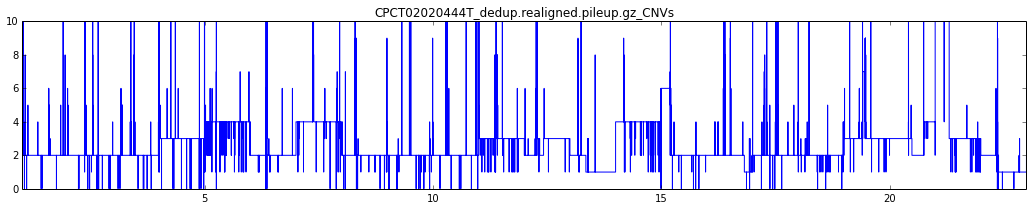

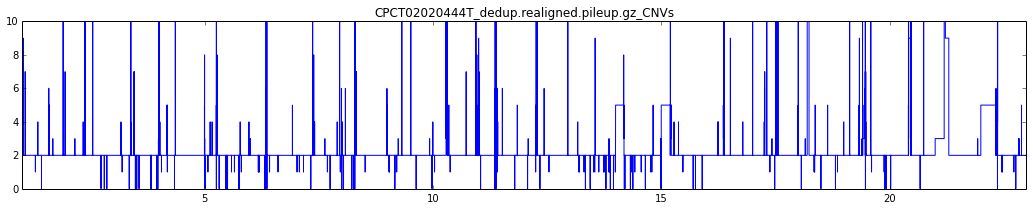

In [65]:
patientName=normalCNVFileName[:12]
dfTumorCNV = loadCNVforPatient(CSV_PATH+tumorCNVFileName,patientName)
dfNormalCNV = loadCNVforPatient(CSV_PATH+normalCNVFileName,patientName)
positionChart(dfTumorCNV,tumorCNVFileName,"copyNum")
positionChart(dfNormalCNV,tumorCNVFileName,"copyNum")


### Read Ratio Analysis by Chromsome

In [121]:
dfTumorRatio = pd.read_table(CSV_PATH + tumorRatioFileName, header=0)#names = ['chrom','window',"ratio","segmentRatio","copyNum","mbaf","baf","GT","uncertainty"] )
dfNormalRatio = pd.read_table(CSV_PATH + normalRatioFileName, header=0)# names = ['chrom','window',"ratio","segmentRatio","copyNum","mbaf","baf","GT","uncertainty"] )
dfTumorRatio.set_index(['Chromosome','Start'],inplace=True)
dfNormalRatio.set_index(['Chromosome','Start'],inplace=True)
dfTumorRatio = pd.merge(dfTumorRatio,dfNormalRatio,how='inner', left_index=True,right_index=True)
#dfTumorRatio = dfTumorRatio[(dfTumorRatio.Ratio_y > 0)]
dfTumorRatio['ratio']= pd.to_numeric(dfTumorRatio['Ratio_x'],errors=coerce) /pd.to_numeric(dfTumorRatio['Ratio_y'],errors=coerce)
dfTumorRatio = dfTumorRatio.reset_index()
dfTumorRatio['chromPos'] = dfTumorRatio['Chromosome'].apply(lambda x: cd.intChrom(str(x))) + \
    dfTumorRatio['Start']/dfTumorRatio['Chromosome'].map(lambda x: cd.chromosomeLength[str(x)])
dfTumorRatio['Chromosome'] = dfTumorRatio['Chromosome'].apply(lambda x: cd.intChrom(str(x)))

In [67]:
#dfTumorRatio[(dfTumorRatio.CopyNumber_x<>2)&(dfTumorRatio.CopyNumber_y==2)&(dfTumorRatio.Ratio_x>0)]\
#[['Chromosome','Start','CopyNumber_x','Ratio_x','Ratio_y','MedianRatio_x','MedianRatio_y','ratio']].head(1)

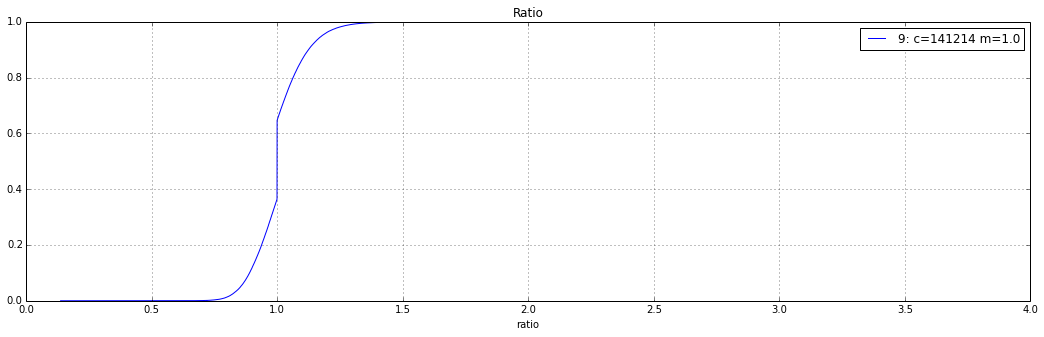

In [135]:
chromosomes = #dfTumorRatio['Chromosome'].unique()
for chromosome in chromosomes:
    ser = dfTumorRatio[dfTumorRatio.Chromosome==chromosome]['ratio'] / NORM
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=str(chromosome)+": c="+str(ser.count())+" m="+str(round(ser.median(),4)))
    ser_cdf.plot(drawstyle='steps',legend=True, title="Ratio",figsize=[18,5],xlim=[0,4],ylim=[0,1],grid=True)

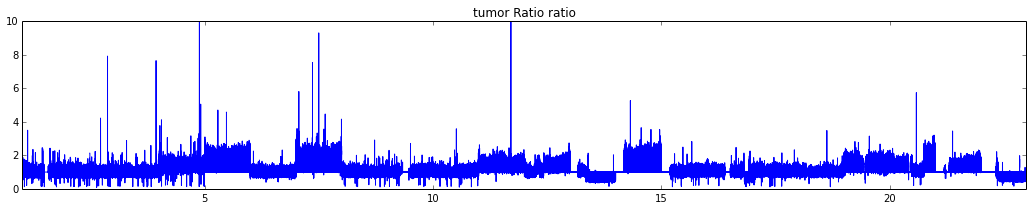

In [124]:
positionChart(dfTumorRatio,"tumor Ratio","ratio")

In [125]:
dfTumorCNV['nonZeroCount'],dfTumorCNV['tumorRatio'],dfTumorCNV['normalRatio'] \
    ,dfTumorCNV['tumorMedianRatio'],dfTumorCNV['normalMedianRatio'] = \
    np.vectorize(nonZeroCountBetween)(dfTumorCNV['chrom'], dfTumorCNV['posStart'],dfTumorCNV['posEnd'])
dfTumorCNV['ratioOfRatio']=dfTumorCNV.tumorRatio/dfTumorCNV.normalRatio

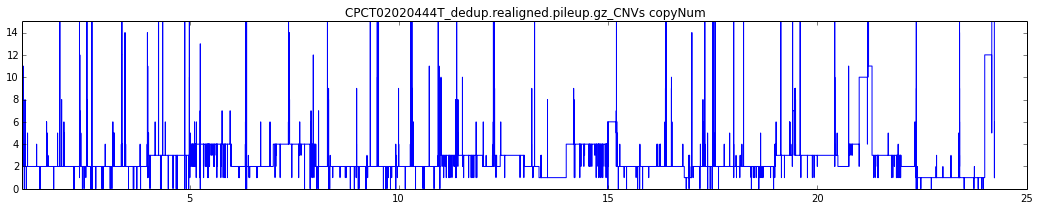

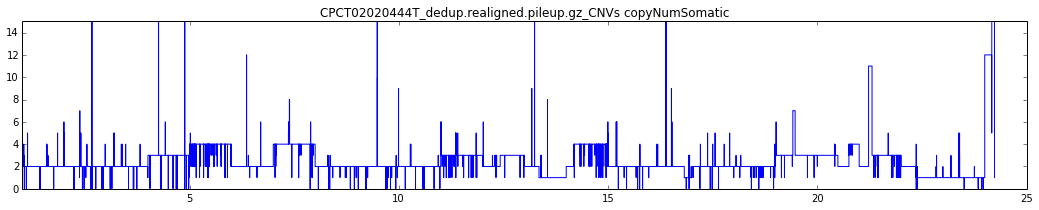

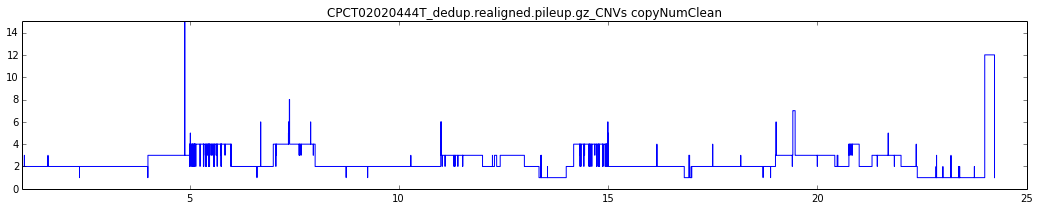

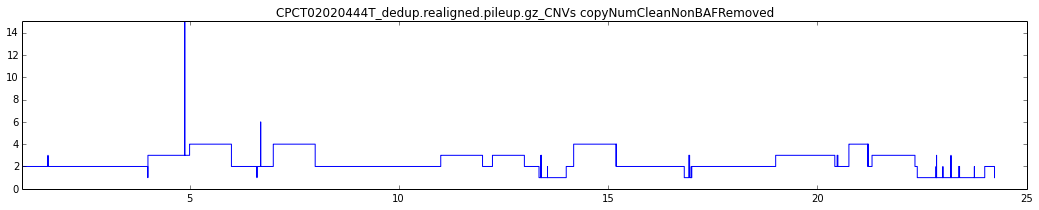

In [451]:
dfTumorCNV = calculateSomaticCNV(dfTumorCNV)
dfTumorCNV = calculateCleanCNV(dfTumorCNV)
dfTumorCNV = cleanNONBAFregionsCNV(dfTumorCNV)
positionChart(dfTumorCNV,tumorCNVFileName,"copyNum",1,25,15)
positionChart(dfTumorCNV,tumorCNVFileName,"copyNumSomatic",1,25,15)
positionChart(dfTumorCNV,tumorCNVFileName,"copyNumClean",1,25,15)
positionChart(dfTumorCNV,tumorCNVFileName,"copyNumCleanNonBAFRemoved",1,25,15)

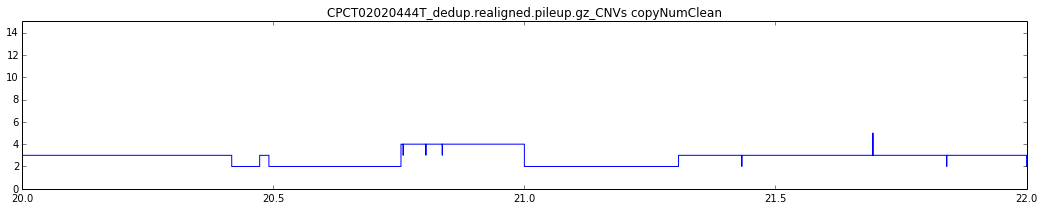

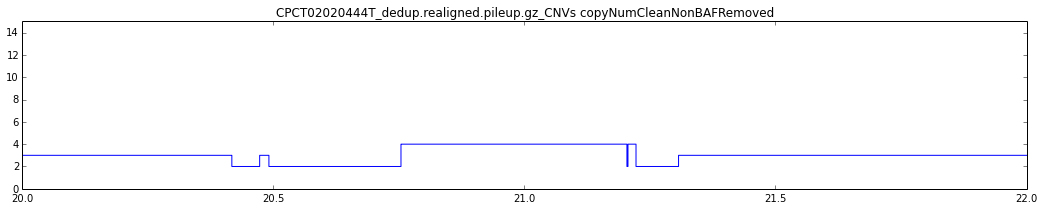

In [452]:
positionChart(dfTumorCNV,tumorCNVFileName,"copyNumClean",20,22,15)
positionChart(dfTumorCNV,tumorCNVFileName,"copyNumCleanNonBAFRemoved",20,22,15)

In [453]:
(dfTumorCNV[(dfTumorCNV.chromPos>20.9)]).head(25)

,index,chrom,posStart,posEnd,copyNum,gainOrLoss,BAF,na,germlineOrSomatic,nothing,chromPos,cappedCopyNum,regionLength,patientName,nonZeroCount,tumorRatio,normalRatio,tumorMedianRatio,normalMedianRatio,copyNumTest,ratioOfRatio,copyNumTest2,copyNumClean,copyNumSomatic,copyNumCleanAndBAFCorrected,copyNumCleanNonBAFRemoved
2585,2007,20,57304000,57341000,4,gain,-,-1,somatic,0,20.909219,4,37000,CPCT02020444,37,1.802768,0.926151,1.82053,0.946946,4,1.946517,4,4,4,4,4
2586,2008,20,57341000,58294000,4,gain,AABB,0.527812,somatic,0,20.909806,4,953000,CPCT02020444,930,1.801477,0.967814,1.81443,0.979038,4,1.861386,4,4,4,4,4
2587,2009,20,58294000,58324000,4,gain,-,-1,somatic,0,20.924927,4,30000,CPCT02020444,30,1.824215,1.020090,1.84933,0.988513,4,1.788288,4,4,4,4,4
2588,2010,20,58324000,58590000,4,gain,AABB,35.0476,somatic,0,20.925403,4,266000,CPCT02020444,260,1.822717,1.009065,1.83162,0.988513,4,1.806343,4,4,4,4,4
2589,2011,20,58590000,58597000,4,gain,-,-1,somatic,0,20.929623,4,7000,CPCT02020444,7,1.824283,0.923173,1.84860,0.988513,4,1.976102,4,4,4,4,4
2590,2012,20,58597000,58752000,4,gain,AABB,1.35718,somatic,0,20.929734,4,155000,CPCT02020444,152,1.827272,1.044561,1.82727,0.988513,4,1.749320,4,4,4,4,4
2591,2013,20,58752000,58759000,4,gain,-,-1,somatic,0,20.932194,4,7000,CPCT02020444,7,1.811264,1.032745,1.79327,0.988513,4,1.753835,4,4,4,4,4
2592,2014,20,58759000,58797000,4,gain,AABB,48.8174,somatic,0,20.932305,4,38000,CPCT02020444,37,1.826545,1.045538,1.83621,0.988513,4,1.746990,4,4,4,4,4
2593,2015,20,58797000,58812000,4,gain,-,-1,somatic,0,20.932908,4,15000,CPCT02020444,15,1.827697,0.962987,1.84049,0.988513,4,1.897945,4,4,4,4,4
2594,2016,20,58812000,59198000,4,gain,AABB,0.609377,somatic,0,20.933146,4,386000,CPCT02020444,371,1.824666,0.996989,1.83132,0.988513,4,1.830177,4,4,4,4,4


In [255]:
dfTumorCNV[(((dfTumorCNV.normalRatio<0.7)&(dfTumorCNV.gainOrLoss=='loss')&(dfTumorCNV.tumorRatio/dfTumorCNV.normalRatio>0.3)) | \
            ((dfTumorCNV.normalRatio>1.4)&(dfTumorCNV.gainOrLoss=='gain')&(dfTumorCNV.tumorRatio/dfTumorCNV.normalRatio<10))) \
          & (dfTumorCNV.germlineOrSomatic == 'somatic')& (dfTumorCNV.copyNum <>2)& (dfTumorCNV.chrom==19)].sort_values('ratioOfRatio')

,index,chrom,posStart,posEnd,copyNum,gainOrLoss,BAF,na,germlineOrSomatic,nothing,chromPos,cappedCopyNum,regionLength,patientName,nonZeroCount,tumorRatio,normalRatio,tumorMedianRatio,normalMedianRatio,copyNumTest,ratioOfRatio,copyNumTest2,copyNumClean,copyNumSomatic
2400,1826,19,12694000,12699000,1,loss,A,-1,somatic,0,19.214683,1,5000,CPCT02020444,5,0.539034,0.532659,0.522592,0.925272,2,1.011968,1,3,1
2459,1884,19,54556000,54561000,1,loss,A,-1,somatic,0,19.922661,1,5000,CPCT02020444,5,0.514255,0.500944,0.520607,0.929283,2,1.026571,1,3,1
2394,1820,19,8410000,8415000,1,loss,A,-1,somatic,0,19.142231,1,5000,CPCT02020444,5,0.548839,0.448439,0.482839,0.905725,2,1.223887,1,3,1
2422,1847,19,27792000,27837000,4,gain,-,-1,somatic,0,19.470023,4,45000,CPCT02020444,37,2.709776,2.027400,1.988350,1.983468,2,1.336577,4,3,4
2419,1844,19,27741000,27767000,4,gain,-,-1,somatic,0,19.469161,4,26000,CPCT02020444,19,2.279014,1.627254,2.040480,1.654978,2,1.400527,4,3,4
2390,1816,19,879000,880000,6,gain,-,-1,somatic,0,19.014866,5,1000,CPCT02020444,1,3.013720,1.969130,3.013720,0.882877,2,1.530483,6,3,6
2416,1841,19,24513000,24594000,7,gain,-,-1,somatic,0,19.414568,5,81000,CPCT02020444,69,3.622898,2.311705,3.398670,2.233147,2,1.567197,7,3,7
2447,1872,19,45170000,45172000,1,loss,A,-1,somatic,0,19.763923,1,2000,CPCT02020444,2,0.369103,0.217389,0.369103,0.915629,2,1.697893,1,3,1
